# Прогнозирование температуры звезды

## Введение

**Цель работы:**
Разработать нейронную сеть для прогнозирования температуры звезды.

**Задачи работы:**
1. Обработать предоставленные данные.
2. Разработать базовую модель.
3. Усовершенноствовать модель для достижения RMSE < 4500.

**План работы:**
1. Загрузка данных.
2. Обработка пропусков и дубликатов, если есть.
3. Исследовательский анализ данных.
4. Корреляционный анализ данных.
5. Подготовка данных для обучения (разделение, масштабирование)
6. Формирование базовой нейросети.
7. Усовершенствование нейросети.
8. Сведение полученных данных в общую таблицу.

**Описание работы**

Инициатор данной задачи - обсерватория «Небо на ладони». Необходимо с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта пользуются методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

В базе обсерватории есть характеристики уже 240 звёзд.
Характеристики:
- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

### Установка и загрузка библиотек

Сначала установим и загрузим нужные библиотеки.

In [ ]:
! pip install phik -q
!pip install scikit-learn==1.5.2 -q

In [ ]:
# Стандартные библиотеки
import pandas as pd
import numpy as np

from math import ceil

# Библиотеки для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотеки для анализа данных
import phik
from phik.report import plot_correlation_matrix
from phik import report
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler
)

# импорт PyTorch
import torch
import torch.nn as nn

Библиотеки загружены.

### Формирование функций

Подготовим функции для работы и анализа.

In [ ]:
def lunge_analysis(df, columns, groups, hue):
    """
    Функция строит боксплоты и гистограммы по переданному списку столбцов и с группировкой по одному категориальному признаку.

    Параметры:
        df: датафрейм с нужными значениями.
        columns: список названий столбцов, по которым надо построить диаграммы.
        groups: столбец из датафрейма с категориальными значениями.

    Возвращает:
        Оформленные боксплоты и гистограммы.

    """
    for column in columns:
        f, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax_1 = sns.histplot(data=df, x=column, hue=hue, ax=ax[0])
        ax_1.set (xlabel=column, ylabel='Количество', title=f'Гистограмма по столбцу {column}')
        ax_2 = sns.boxplot(data=df, y=column, ax=ax[1], width=.2)
        ax_2.set (xlabel=column, ylabel='Значение', title=f'Диаграмма размаха признака {column}')
        plt.show()
    for group in groups:
        f, ax = plt.subplots(1, 1, figsize=(10, 8))
        ax_3 = plt.pie(df[group].value_counts(), labels=df[group].value_counts().index.tolist(), colors=sns.color_palette('bright'), autopct='%.0f%%')
        plt.title(f'Круговая диаграмма для признака {group}')
        plt.show()

In [ ]:
# Функция присваивает категорию цвета звезды.
def cat_type_color(df):
    color = ''
    if df in blue_color:
        color = 'blue'
    elif df in white_blue_color:
        color = 'white_blue_color'
    elif df in white_color:
        color = 'white'
    elif df  in yellow_white_color:
        color = 'yellow_white'
    elif df == 'Red':
        color = 'red'
    else:
        color = 'other'
    return color

Функции подготовлены.

### Загрузка датасетов

Загрузим датасет.

In [ ]:
df = pd.read_csv('/datasets/6_class.csv')

In [ ]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Датасет загружен, все типы опредилились верно.

## Предобработка и анализ данных

### Предобработка данных

Названия столбцов некорректны. Изменим их.

In [ ]:
rename_columns = {'Unnamed: 0':'unnamed',
                 'Temperature (K)':'temperature_(K)',
                  'Luminosity(L/Lo)':'luminosity_(L/Lo)',
                  'Radius(R/Ro)':'radius_(R/Ro)',
                  'Absolute magnitude(Mv)':'absolute_magnitude_(Mv)',
                  'Star type':'star_type',
                  'Star color':'star_color'
                 }

In [ ]:
df = df.rename(columns=rename_columns)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   unnamed                  240 non-null    int64  
 1   temperature_(K)          240 non-null    int64  
 2   luminosity_(L/Lo)        240 non-null    float64
 3   radius_(R/Ro)            240 non-null    float64
 4   absolute_magnitude_(Mv)  240 non-null    float64
 5   star_type                240 non-null    int64  
 6   star_color               240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


Пропусков нет, типы определились верно. Проверим на полные дубликаты

In [ ]:
df.columns

Index(['unnamed', 'temperature_(K)', 'luminosity_(L/Lo)', 'radius_(R/Ro)',
       'absolute_magnitude_(Mv)', 'star_type', 'star_color'],
      dtype='object')

In [ ]:
df.duplicated().sum()

0

Полных дубликатов нет.

Так как столбец unnamed совпадает с индексами, удалим его из датафрейма:

In [ ]:
df = df.drop('unnamed', axis=1)

### Исследовательский анализ данных

Посмотрим на структуру данных. Столбец, в котором наиболее вероятны неявные дубликаты - star_color. Проверим его.

In [ ]:
df['star_color'].value_counts()

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
white                   3
Yellowish White         3
Whitish                 2
Orange                  2
yellowish               2
Yellowish               1
Orange-Red              1
Blue                    1
White-Yellow            1
Blue-White              1
Pale yellow orange      1
Blue white              1
Name: star_color, dtype: int64

Много неявных дубликатов в столбце с цветом звезды. Обработаем их.

In [ ]:
blue_color = ['Blue', 'Blue ']
white_blue_color = ['Blue-white', 'Blue White', 'Blue white', 'Blue-White', 'Blue white', 'Blue white ']
white_color = ['White', 'white', 'Whitish']
yellow_white_color = ['yellow-white', 'Yellowish White', 'White-Yellow']
other = ['Orange', 'yellowish', 'Pale yellow orange', 'Orange-Red', 'Yellowish']

In [ ]:
df['type_color'] = df['star_color'].apply(cat_type_color)

In [ ]:
df.head()

,temperature_(K),luminosity_(L/Lo),radius_(R/Ro),absolute_magnitude_(Mv),star_type,star_color,type_color
0,3068,0.002400,0.1700,16.12,0,Red,red
1,3042,0.000500,0.1542,16.60,0,Red,red
2,2600,0.000300,0.1020,18.70,0,Red,red
3,2800,0.000200,0.1600,16.65,0,Red,red
4,1939,0.000138,0.1030,20.06,0,Red,red


Неявные дубликаты обработаны.

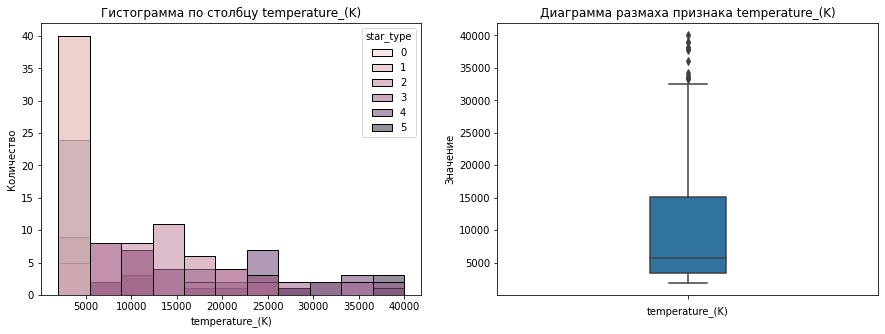

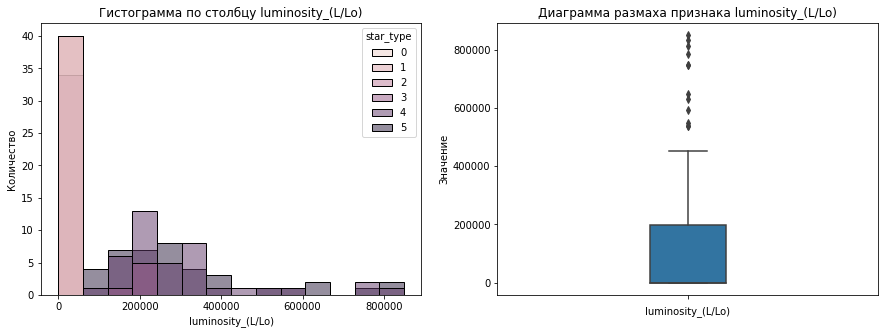

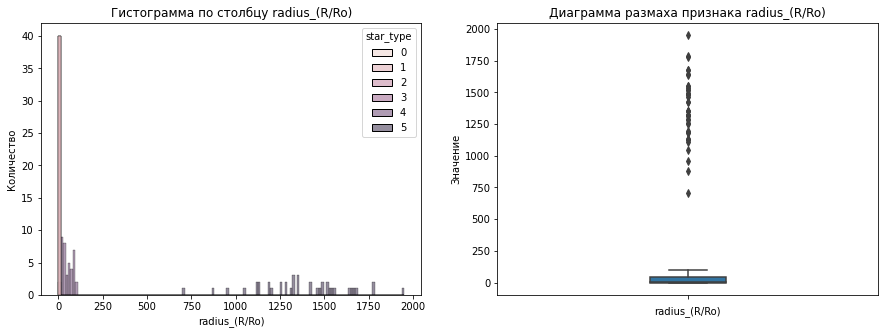

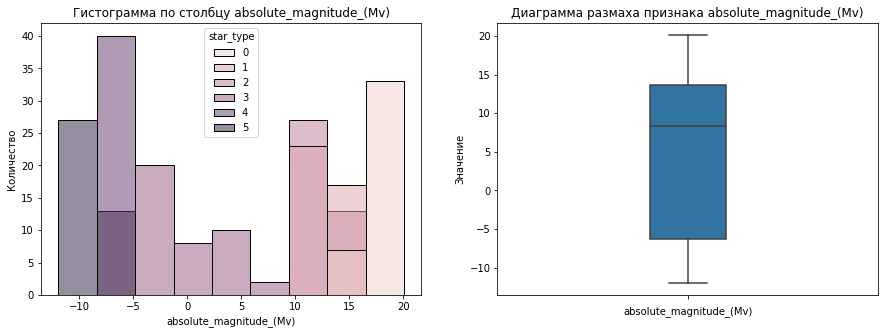

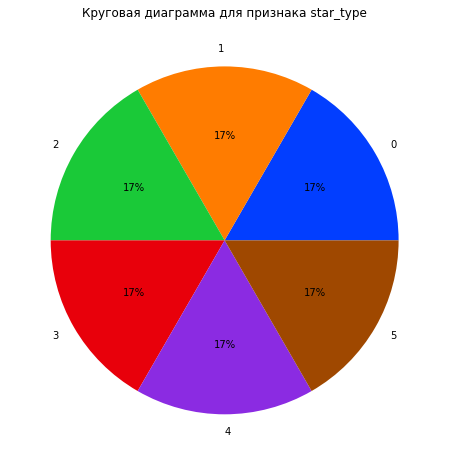

In [ ]:
lunge_analysis(df, ['temperature_(K)', 'luminosity_(L/Lo)', 'radius_(R/Ro)', 'absolute_magnitude_(Mv)'],
               ['star_type'], 'star_type')

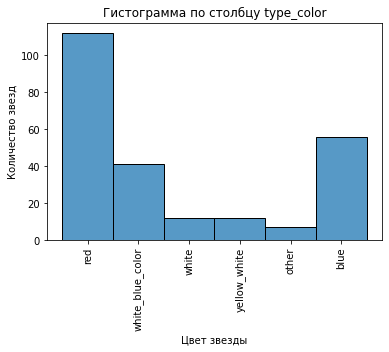

In [ ]:
ax = sns.histplot(data=df, x='type_color')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Цвет звезды', ylabel='Количество звезд', title=f'Гистограмма по столбцу type_color')
plt.show()

Данных у нас немного и удалять выпады может быть опасно. Неявные дубликаты в столбце star_color обработали ранее.

In [ ]:
#Старый код, оставлен для сведения
#df['star_color'].unique()
#df['star_color'] = df['star_color'].replace('Blue ', 'Blue')
#df['star_color'] = df['star_color'].replace(['Blue-White', 'Blue white', 'Blue white ', 'Blue White'], 'Blue-white')
#df['star_color'] = df['star_color'].replace('Pale yellow orange', 'Pale-yellow-orange')
#df['star_color'] = df['star_color'].replace('white', 'White')
#df['star_color'] = df['star_color'].replace('Yellowish White', 'Yellowish-white')
#df['star_color'] = df['star_color'].replace('yellow-white', 'Yellow-white')
#df['star_color'] = df['star_color'].replace('White-Yellow', 'White-yellow')
#df['star_color'] = df['star_color'].replace('yellowish', 'Yellowish')
#df['star_color'] = df['star_color'].replace('Orange-Red', 'Orange-red')

In [ ]:
#Старый код, остален для сведения
#lunge_analysis(df, ['temperature_(K)', 'luminosity_(L/Lo)', 'radius_(R/Ro)', 'absolute_magnitude_(Mv)'],
#               ['star_type', 'star_color'], 'star_type')

### Корреляционный анализ

Построим матрицу корреляции.

In [ ]:
corr_columns = ['temperature_(K)', 'luminosity_(L/Lo)', 'radius_(R/Ro)',
       'absolute_magnitude_(Mv)', 'star_type', 'type_color']

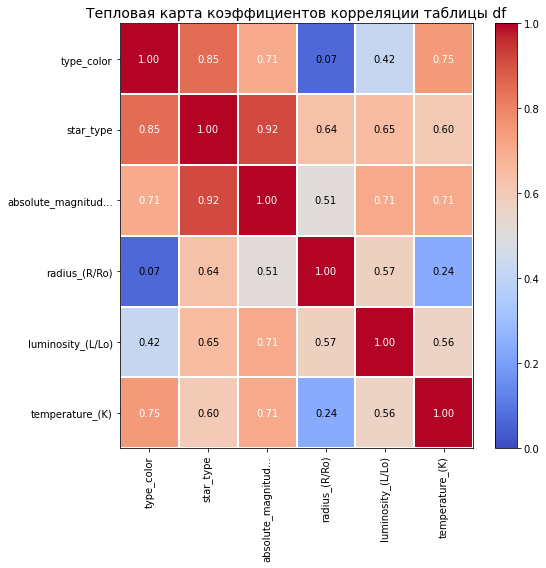

In [ ]:
phik_overview = df[corr_columns].phik_matrix(interval_cols=['temperature_(K)',
                                                            'luminosity_(L/Lo)',
                                                            'radius_(R/Ro)',
                                                            'absolute_magnitude_(Mv)'])
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="coolwarm",
                        title="Тепловая карта коэффициентов корреляции таблицы df",
                        fontsize_factor=1,
                        figsize=(8, 8))
plt.tight_layout()
plt.show()

Мультиколлениарности нет. Целевой признак, температура, коррелирует со всеми признаками.

### Подготовка данных для обучения

In [ ]:
#Старый код, остален для сведения
#df['type_color'] = df['star_color'].apply(cat_type_color)

#df['strat_temp'] = pd.qcut(df['temperature_(K)'], q=10)

Теперь разобъем данные на выборки.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['temperature_(K)', 'star_color']),
    df['temperature_(K)'],
    test_size=0.3,
    shuffle=True,
    random_state=42,
    stratify = df['type_color']
)

In [ ]:
num_columns = ['luminosity_(L/Lo)', 'absolute_magnitude_(Mv)', 'radius_(R/Ro)']

In [ ]:
cat_columns = ['star_type',
               'type_color'
              ]

Масштабируем данные

In [ ]:
scaler = MinMaxScaler()

In [ ]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output = False)

In [ ]:
X_train_ohe = ohe.fit_transform(X_train[cat_columns])
X_test_ohe = ohe.transform(X_test[cat_columns])

In [ ]:
cat_ohe_name = ohe.get_feature_names_out()

In [ ]:
X_train_ohe = pd.DataFrame(X_train_ohe, columns=cat_ohe_name)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=cat_ohe_name)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

In [ ]:
X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
X_train.shape, X_test.shape

((168, 13), (72, 13))

Признаки подготовили. Переведем теперь их в тензор:

In [ ]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

Данные подготовили.

## Построение базовой нейронной сети

Сформируем нейросеть:

In [ ]:
# Задаю параметры нейронной сети
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.LeakyReLU(),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.Linear(n_hidden_neurons_2, n_out_neurons)
)

In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

#loss = nn.L1Loss()
loss = nn.MSELoss()

num_epochs = 5000

Обучим её:

In [ ]:
for epoch in range(num_epochs):
    optimizer.zero_grad()

    preds = net.forward(X_train).flatten()

    loss_value = loss(preds, y_train)

    loss_value.backward()

    optimizer.step()

    if epoch % 500 == 0 or epoch == num_epochs - 1:
        net.eval()
        test_preds = net.forward(X_test).flatten()
        rmse = torch.sqrt(1/X_test.shape[0] * torch.sum(torch.pow((test_preds - y_test), 2)))
        print(rmse)
        net.train()

tensor(12962.7676, grad_fn=<SqrtBackward0>)
tensor(12799.3828, grad_fn=<SqrtBackward0>)
tensor(11763.4600, grad_fn=<SqrtBackward0>)
tensor(10024.1270, grad_fn=<SqrtBackward0>)
tensor(8438.4990, grad_fn=<SqrtBackward0>)
tensor(7593.3979, grad_fn=<SqrtBackward0>)
tensor(7235.3481, grad_fn=<SqrtBackward0>)
tensor(7093.6064, grad_fn=<SqrtBackward0>)
tensor(7048.4272, grad_fn=<SqrtBackward0>)
tensor(7003.6655, grad_fn=<SqrtBackward0>)
tensor(6916.3838, grad_fn=<SqrtBackward0>)


Для построения графика получим предсказания по всему датасету.

In [ ]:
temp_ohe = ohe.transform(df[cat_columns])
temp_scaled = scaler.transform(df[num_columns])

In [ ]:
temp_ohe = pd.DataFrame(temp_ohe, columns=cat_ohe_name)
temp_scaled = pd.DataFrame(temp_scaled, columns=num_columns)

In [ ]:
temp = pd.concat([temp_ohe, temp_scaled], axis=1)

In [ ]:
temp = torch.Tensor(temp.values)

In [ ]:
net.eval()

Sequential(
  (0): Linear(in_features=13, out_features=20, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=20, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
temp_pred = net.forward(temp)

In [ ]:
temp_pred = pd.DataFrame(temp_pred.detach().numpy())

In [ ]:
temp_pred = temp_pred.rename(columns={0:'temp_pred'})

In [ ]:
df = df.join(temp_pred)

In [ ]:
df.head(3)

,temperature_(K),luminosity_(L/Lo),radius_(R/Ro),absolute_magnitude_(Mv),star_type,star_color,type_color,temp_pred
0,3068,0.0024,0.1700,16.12,0,Red,red,2918.069092
1,3042,0.0005,0.1542,16.60,0,Red,red,2943.464355
2,2600,0.0003,0.1020,18.70,0,Red,red,3054.588867


Построим график:

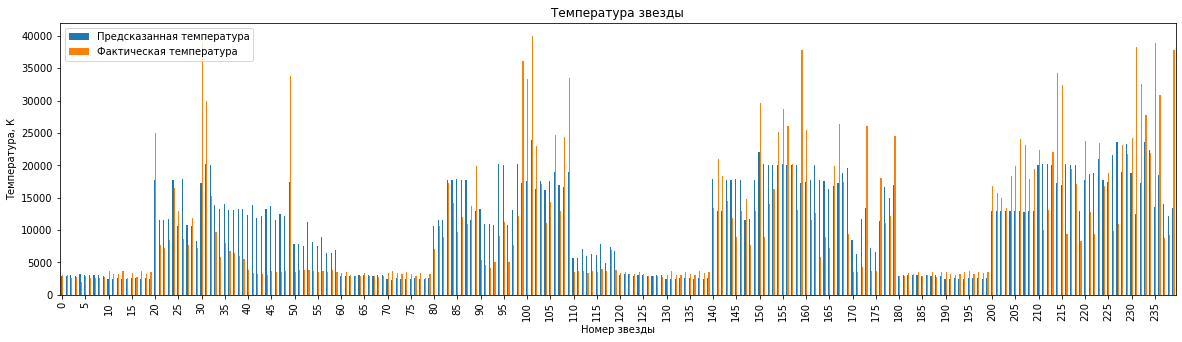

In [ ]:
df.loc[:,['temp_pred','temperature_(K)']].plot(kind='bar', grid=False, figsize=(20, 5))
plt.title('Температура звезды')
plt.legend(['Предсказанная температура', 'Фактическая температура'])
plt.xticks(np.arange(0,240,5))
plt.xlabel('Номер звезды')
plt.ylabel('Температура, К')
plt.show()

График построен. Как видно, он не точно отражает температуру звезды.

Плохо прогнозируются температуры у звезд с высокими температурами (к примеру, 31, 32, 98, 99, 239), а также звезды с номерами 33 по 58. Посмотрим на них:

In [ ]:
df[31:58]

,temperature_(K),luminosity_(L/Lo),radius_(R/Ro),absolute_magnitude_(Mv),star_type,star_color,type_color,temp_pred
31,30000,28840.000,6.300,-4.20,3,Blue-white,white_blue_color,20242.337891
32,15276,1136.000,7.200,-1.97,3,Blue-white,white_blue_color,20056.382812
33,9700,74.000,2.890,0.16,3,Whitish,white,13894.093750
34,5800,0.810,0.900,5.05,3,yellow-white,yellow_white,13216.826172
35,8052,8.700,1.800,2.42,3,Whitish,white,14011.771484
36,6757,1.430,1.120,2.41,3,yellow-white,yellow_white,13077.310547
37,6380,1.350,0.980,2.93,3,yellow-white,yellow_white,13104.679688
38,5936,1.357,1.106,4.46,3,yellow-white,yellow_white,13185.831055
39,5587,0.819,0.990,5.03,3,yellow-white,yellow_white,13215.871094
40,3826,200000.000,19.000,-6.93,4,Red,red,12296.871094


Температура красных звезд завышается, температура бело-голубых наоборот занижается.

## Улучшение нейронной сети

Введем обучение по батчам.

In [ ]:
%%time
# Задаю параметры нейронной сети. Ячейка выполняется около 20 минут.

n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 20
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = nn.Sequential(
    nn.Linear(n_in_neurons, n_hidden_neurons_1),
    nn.LeakyReLU(),
    nn.BatchNorm1d(n_hidden_neurons_1),
    nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2),
    nn.ReLU(),
    nn.BatchNorm1d(n_hidden_neurons_2),
    nn.Linear(n_hidden_neurons_2, n_out_neurons),
)

optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.MSELoss()

num_epochs = 2000


batch_sizes = [2, 5, 10, 20, 30]
rmse_list = []

for batch_size in batch_sizes:
    num_batches = ceil(len(X_train)/batch_size)

    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train)) # случайная перестановка индексов объектов
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size # считаю номер стартового объекта батча
            optimizer.zero_grad()

            batch_indexes = order[start_index:start_index+batch_size] # извлекаю индексы объектов текущего батча
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = net.forward(X_batch).flatten()

            loss_value = loss(preds, y_batch)

            loss_value.backward()

            optimizer.step()

        if epoch == num_epochs - 1:
            net.eval()
            test_preds = net.forward(X_test).flatten()
            rmse = torch.sqrt(1/X_test.shape[0] * torch.sum(torch.pow((test_preds - y_test), 2)))
            rmse_list.append(rmse)
            print(f'при batch = {batch_size} RMSE = {rmse}')
            net.train()

при batch = 2 RMSE = 4903.90625
при batch = 5 RMSE = 4732.0322265625
при batch = 10 RMSE = 4437.62255859375
при batch = 20 RMSE = 4040.168701171875
при batch = 30 RMSE = 3549.641845703125
CPU times: user 48min 18s, sys: 16.4 s, total: 48min 34s
Wall time: 1h 8min 54s


Минимальное значение при batch = 30. В этом случае RMSE = 3800.

Получим предсказания на всём датасете и построим график.

In [ ]:
net.eval()

Sequential(
  (0): Linear(in_features=13, out_features=20, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=20, out_features=10, bias=True)
  (4): ReLU()
  (5): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
temp_pred_update = net.forward(temp)

In [ ]:
temp_pred_update = pd.DataFrame(temp_pred_update.detach().numpy())

In [ ]:
temp_pred_update = temp_pred_update.rename(columns={0:'temp_pred_update'})

In [ ]:
df = df.join(temp_pred_update)

In [ ]:
df.head(3)

,temperature_(K),luminosity_(L/Lo),radius_(R/Ro),absolute_magnitude_(Mv),star_type,star_color,type_color,temp_pred,temp_pred_update
0,3068,0.0024,0.1700,16.12,0,Red,red,2918.069092,2876.701416
1,3042,0.0005,0.1542,16.60,0,Red,red,2943.464355,2941.786133
2,2600,0.0003,0.1020,18.70,0,Red,red,3054.588867,3226.649658


Построим график:

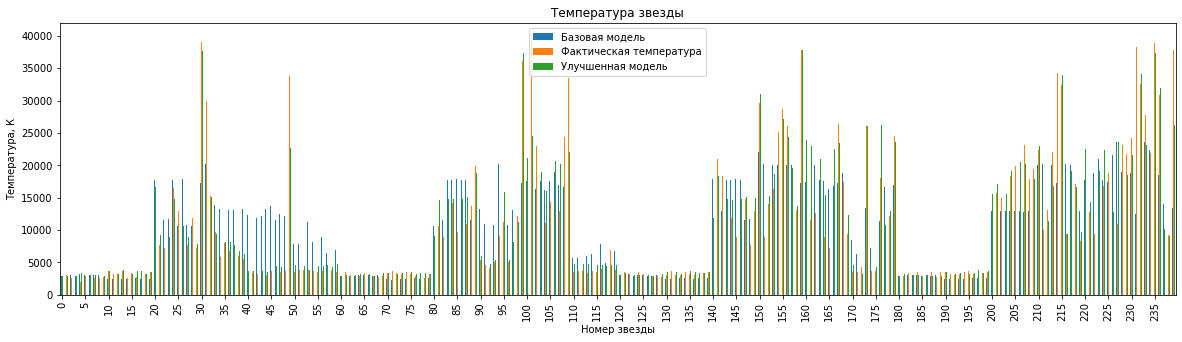

In [ ]:
df.loc[:,['temp_pred','temperature_(K)', 'temp_pred_update']].plot(kind='bar', grid=False, figsize=(20, 5))
plt.title('Температура звезды')
plt.legend(['Базовая модель', 'Фактическая температура', 'Улучшенная модель'])
plt.xticks(np.arange(0,240,5))
plt.xlabel('Номер звезды')
plt.ylabel('Температура, К')
plt.show()

Как видно из графика, зеленные столбцы, которые соответствуют улучшенной модели, лучше совпадают с фактической температурой (оранжевые столбцы)

## Выводы

В рамках работы сделано:
1. Проведен исследовательский и корреляционный анализ.
2. Сформирована базовая нейросеть.
3. Улучшена базовая нейросеть.

Результаты работы:
1. В качестве базовой нейросети выбрана нейросеть из двух скрытых слоев. В первом слое 20 нейронов, во втором - 10. В качестве функций активации использовали LeakyReLU() и ReLU(). Метрика RMSE на этой модели после 5000 эпох обучения составила 6900.
2. Базовую нейросеть улучшили путем проведения обучения по batch и с применением Batch Normalization. Достигнутая метрика RMSE составила 3800, что меньше 4500.

Рекомендации для улучшения анализа:
1. Ввести более четкое описание цвета, возможно, с применением длины волны, для устранения двусмысленности.
2. Добавить большее количество наблюдений.